<a href="https://colab.research.google.com/github/sunny0103/DeepLearning_nlp_projects/blob/main/Finance_news/Finance_news_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers datasets

### Finance News data load
레이블, 영어, 한국어로 구성되어 있으며, Neutral, positive, negative 3개의 레이블로 구성 되어 있다.

In [2]:
!wget https://raw.githubusercontent.com/ukairia777/finance_sentiment_corpus/main/finance_data.csv

--2023-10-19 03:20:12--  https://raw.githubusercontent.com/ukairia777/finance_sentiment_corpus/main/finance_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1319001 (1.3M) [text/plain]
Saving to: ‘finance_data.csv.2’

finance_data.csv.2  100%[===================>]   1.26M  --.-KB/s    in 0.02s   

2023-10-19 03:20:12 (58.5 MB/s) - ‘finance_data.csv.2’ saved [1319001/1319001]



In [3]:
import random
import os
import gc
from tqdm import tqdm, tqdm_notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from  sklearn.model_selection import train_test_split
from sklearn.metrics import (f1_score,
                             roc_auc_score,
                             accuracy_score,
                             hamming_loss
                             )

from torch.nn.utils.rnn import pad_sequence
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (AutoTokenizer,
                          AutoModelForSequenceClassification,
                          AdamW,
                          get_linear_schedule_with_warmup,
                          )



plt.style.use('ggplot')

In [4]:
def seed_everything(seed):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

seed = 42
seed_everything(seed)


In [5]:
df = pd.read_csv('finance_data.csv')
df.head()

,labels,sentence,kor_sentence
0,0,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,0,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,2,The international electronic industry company ...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,1,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,1,According to the company's updated strategy fo...,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


In [6]:
df['labels'] = df['labels'].replace(['neutral', 'positive','negative'],[0, 1, 2])
df.head()

,labels,sentence,kor_sentence
0,0,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,0,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,2,The international electronic industry company ...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,1,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,1,According to the company's updated strategy fo...,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


In [7]:
df.isnull().sum()

labels          0
sentence        0
kor_sentence    0
dtype: int64

In [8]:
# df.drop('sentence', axis=1, inplace=True)

In [9]:
df.to_csv('finance_data.csv', index=False, encoding='utf-8-sig')

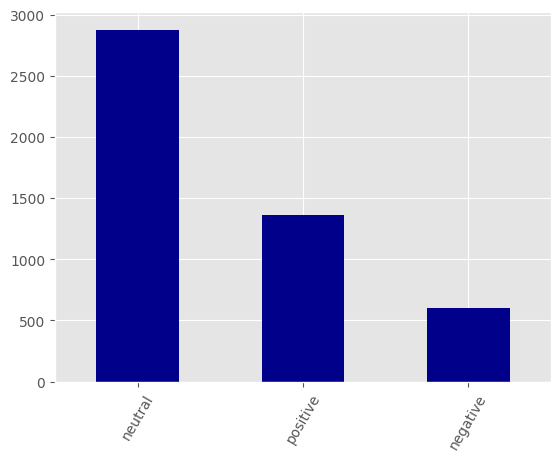

In [10]:
fig, ax = plt.subplots()
df['labels'].value_counts().plot(kind='bar', color='darkblue', ax=ax)
ax.set_xticklabels(['neutral', 'positive','negative'], rotation=60)
plt.show()

* 대부분의 데이터들이 Neutral이고 Negative news는 Neutral의 1/5수준이므로 각 레이블에 대한 데이터 양이 불균형.

In [11]:
X_train, X_val, y_train, y_val = train_test_split(df.index.values,
                                                  df.labels.values,
                                                  test_size=0.3,
                                                  random_state=seed,
                                                  stratify=df.labels.values)

In [12]:
df['data_type'] = ['not_set'] * df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'valid'

In [13]:
df[df['data_type']=='valid']

,labels,sentence,kor_sentence,data_type
1,0,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...,valid
3,1,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...,valid
9,1,"Operating profit totalled EUR 21.1 mn, up from...",영업이익은 총 21.1 유로로 2007년 18.6 mn에서 증가하여 순매출의 9.7...,valid
10,1,TeliaSonera TLSN said the offer is in line wit...,텔리아소네라 TLSN은 이번 제안이 핵심 사업 보유에 대한 지분을 늘리기 위한 전략...,valid
21,1,( Filippova ) A trilateral agreement on invest...,상트페테르부르크의 기술단지 건설에 대한 3국간 투자협정은 오늘 헬싱키에서 개막된 '...,valid
...,...,...,...,...
4810,2,Finnish meat company Atria can no longer promi...,핀란드 육류 회사인 아트리아는 더 이상 고객들에게 충분한 양의 국산 쇠고기를 약속할...,valid
4821,2,"Operating margin, however, slipped to 14.4 % f...","그러나 영업이익률은 15.1%에서 14.4%로 떨어졌으며, 이는 엔터프라이즈 솔루션...",valid
4824,2,"As a result of these transactions, the aggrega...",이러한 거래로 인해 버릴생명과학캐피털펀드 L.P.의 총 보유 지분이 회사 주식 및 ...,valid
4833,2,In Finland's Hobby Hall's sales decreased by 1...,"핀란드 하비홀의 매출은 10% 감소했고, 해외 판매는 19% 감소했다.",valid


In [14]:
X_val, X_test, y_val, y_test = train_test_split(df[df['data_type']=='valid'].index.values,
                                                  df[df['data_type']=='valid'].labels.values,
                                                  test_size=0.5,
                                                  random_state=seed,
                                                  stratify=df[df['data_type']=='valid'].labels.values)

In [15]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

3392
727
727


In [16]:
df.loc[X_test, 'data_type'] = 'test'

In [17]:
# total dataset
train_set = df[df.data_type =='train']
valid_set = df[df.data_type =='valid']
test_set = df[df.data_type =='test']

In [18]:
print(train_set.shape)
print(valid_set.shape)
print(test_set.shape)

(3392, 4)
(727, 4)
(727, 4)


In [19]:
train_set = train_set.reset_index(drop=True)
valid_set = valid_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)

In [20]:
MODEL_NAME = 'klue/bert-base'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [21]:
max_len = 256

class CustomDataset(Dataset):

  def __init__(self, dataset, tokenizer):
    self.dataset = dataset
    self.tokenizer = tokenizer

  def __getitem__(self, index):
    text  =  self.dataset.loc[index, 'kor_sentence']

    encoded_data = self.tokenizer.encode_plus(
        text,
        add_special_tokens= True,
        max_length = max_len,
        padding = 'max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
        )

    input_ids = encoded_data['input_ids'][0]
    attention_masks = encoded_data['attention_mask'][0]

    labels = torch.tensor(self.dataset.loc[index, 'labels'])

    return input_ids, attention_masks, labels

  def __len__(self):
    return len(self.dataset)


In [22]:
train_dataset = CustomDataset(train_set, tokenizer)
valid_dataset = CustomDataset(valid_set, tokenizer)
test_dataset = CustomDataset(test_set, tokenizer)

In [23]:
BATCH_SIZE = 16
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [24]:
# number of labels
num_labels = len(df.labels.unique())

In [25]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LEARNING_RATES = 2e-5
epochs = 10
model = model.to(device)
optimizer = AdamW(model.parameters(), lr = LEARNING_RATES, eps = 1e-8)
total_steps = len(trainloader)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps = total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [27]:
def metrics(predictions, labels):
  y_pred = predictions
  y_true = labels

  accuracy = accuracy_score(y_true, y_pred)
  f1_macro_average = f1_score(y_true=y_true, y_pred=y_pred, average='macro', zero_division=0)
  f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro', zero_division=0)
  f1_weighted_average = f1_score(y_true=y_true, y_pred=y_pred, average='weighted', zero_division=0)

  metrics = {
      'accuracy': accuracy,
      'f1_macro': f1_macro_average,
      'f1_micro': f1_micro_average,
      'f1_weighted':f1_weighted_average
      }
  return metrics

In [28]:
import time
import datetime
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))  # hh:mm:ss

In [29]:
class Trainer():
  def __init__(self, trainloader, validloader, testloader, model, optimizer, scheduler, device):
    self.trainloader = trainloader
    self.validloader = validloader
    self.testloader = testloader
    self.model = model
    self.optimizer = optimizer
    self.scheduler = scheduler
    self.device = device

  def train(self, epochs=1):
    self.model.train()
    best_acc = None
    for epoch in range(1, epochs+1):
      running_loss = 0.0
      t0 = time.time()
      for step, batch  in tqdm(enumerate(self.trainloader)):
        if step % 500 ==0 and not step==0:
          elapsed = format_time(time.time()-t0)
          print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(self.trainloader), elapsed))

        self.optimizer.zero_grad()
        batch = tuple(b.to(self.device) for b in batch)
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }
        outputs = model(**inputs)

        loss = outputs[0]
        running_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        self.optimizer.step()
        self.scheduler.step()

      train_loss = running_loss/len(self.trainloader)
      valid_loss, accuracy = self.validate()
      tqdm.write('Epoch:{:1d}, Train loss: {:.3f}, Validation loss: {:.3f}, Accuracy: {:.3f}'.format(epoch, train_loss, valid_loss, accuracy))
      print(" Training epcoh took: {:}".format(format_time(time.time() - t0)))
      print("=================================================================================")

      if best_acc is None:
        best_acc  = accuracy
        torch.save(model.state_dict(), f'./Bert.model')
      elif best_acc < accuracy:
        best_acc = accuracy
        torch.save(model.state_dict(), f'./Bert.model')
      else:
        break


  def validate(self):
    self.model.eval()
    predictions, true_vals =[], []
    with torch.no_grad():
      running_loss = 0.0
      for batch in self.validloader:
        batch = tuple(b.to(self.device) for b in batch)
        inputs = {'input_ids':      batch[0],
          'attention_mask': batch[1],
          'labels':         batch[2],
        }
        outputs = model(**inputs)

        loss = outputs[0]
        running_loss += loss.item()
        logits = outputs[1]

        logits = logits.detach().cpu().numpy().argmax(1)
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

      valid_loss = running_loss/len(self.validloader)
      predictions = np.concatenate(predictions, axis=0)
      true_vals = np.concatenate(true_vals, axis=0)
      results = metrics(predictions, true_vals)
      print("F1 (Macro) Score: {0:.4f}".format(results['f1_macro']))
      print("F1 (Micro) Score: {0:.4f}".format(results['f1_micro']))
      print("F1 (Weighted) Score: {0:.4f}".format(results['f1_weighted']))
      return valid_loss, results['accuracy']


  def test(self):
    self.model.eval()
    predictions, true_vals =[], []
    with torch.no_grad():
      for batch in self.testloader:
        batch = tuple(b.to(self.device) for b in batch)
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                  }
        outputs = model(**inputs)
        logits = outputs[1]

        logits = logits.detach().cpu().numpy().argmax(1)
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

      predictions = np.concatenate(predictions, axis=0)
      true_vals = np.concatenate(true_vals, axis=0)
      results = metrics(predictions, true_vals)
      print("Accuracy Score: {0:.4f}".format(results['accuracy']))
      print("F1 (Macro) Score: {0:.4f}".format(results['f1_macro']))
      print("F1 (Micro) Score: {0:.4f}".format(results['f1_micro']))
      print("F1 (Weighted) Score: {0:.4f}".format(results['f1_weighted']))

In [30]:
trainer = Trainer(trainloader= trainloader,
                  validloader = validloader,
                  testloader = testloader,
                  model = model,
                  optimizer = optimizer,
                  scheduler = scheduler,
                  device = device)
trainer.train(epochs=epochs)

212it [01:00,  3.48it/s]


F1 (Macro) Score: 0.8219
F1 (Micro) Score: 0.8391
F1 (Weighted) Score: 0.8378
Epoch:1, Train loss: 0.523, Validation loss: 0.390, Accuracy: 0.839
 Training epcoh took: 0:01:04


212it [00:47,  4.48it/s]


F1 (Macro) Score: 0.8219
F1 (Micro) Score: 0.8391
F1 (Weighted) Score: 0.8378
Epoch:2, Train loss: 0.315, Validation loss: 0.390, Accuracy: 0.839
 Training epcoh took: 0:00:51


In [31]:
trainer.test()

Accuracy Score: 0.8377
F1 (Macro) Score: 0.8112
F1 (Micro) Score: 0.8377
F1 (Weighted) Score: 0.8368
